## **Import Libraries**
___

In [85]:
# Analysis Libraries
import pandas as pd
import numpy as np

# Plotting Libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Statistics Libraries
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Misc Libraries
from typing import Optional

## **Read Files**
___

In [86]:
df = pd.read_csv('UsArrests.csv')

## **Dataset Identification**
___

In [87]:
df.axes

[RangeIndex(start=0, stop=50, step=1),
 Index(['City', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')]

In [88]:
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [89]:
df.tail()

,City,Murder,Assault,UrbanPop,Rape
45,Virginia,8.5,156,63,20.7
46,Washington,4.0,145,73,26.2
47,West Virginia,5.7,81,39,9.3
48,Wisconsin,2.6,53,66,10.8
49,Wyoming,6.8,161,60,15.6


## **Dataset Preprocessing**
___

In [90]:
# Return a dataset subset with the non-numeric values only
df.select_dtypes(exclude='number').head()

,City
0,Alabama
1,Alaska
2,Arizona
3,Arkansas
4,California


In [91]:
# Return a dataset subset with the numeric values only
df.select_dtypes(include='number').head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


`NOTES`:

* There is only one non-numeric feature, and all the values are unique, therefore we can make the  City feature the Index of the dataframe.

In [92]:
df.set_index(['City'], inplace=True)
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


#### 1. **Duplicated Values**

In [93]:
# Return the total number of duplicate values
dupes = df.duplicated().sum()
print(f"The total number od duplicate values: {dupes}")

The total number od duplicate values: 0


#### 2. **Null Values**

In [94]:
# Return the total number of null values
nulls = np.count_nonzero(df.isnull().values)
print(f"The total number of null values: {nulls}")

The total number of null values: 0


#### 3. **Outlier Values**

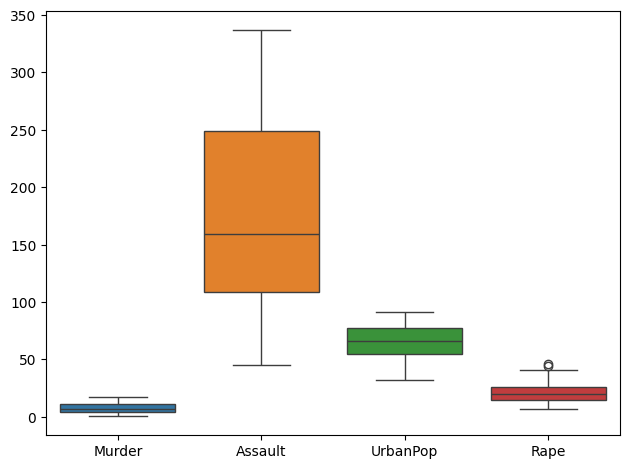

In [95]:
# Visualize the outlier values in the dataset
sns.boxplot(df)
plt.tight_layout()
plt.show()

In [96]:
def outlierIQR(column: str, dataframe: Optional[pd.DataFrame]=df) -> str:
    """
    A function that outputs the total number of outliers for columns with outliers
    and returns the name of the column with the outliers

    Args:
        dataframe: dataframe.
            A pandas dataframe object
        
        column: str.
            Name of a column inn the dataframe object

    Return: 
        column: str.
            Name of the column with an outlier
    """
    # Find the IQR Values
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)

    IQR = q3 - q1 

    # Find the outlier values 
    upper = dataframe[column] > q3 + (1.5 * IQR)
    lower = dataframe[column] < q1 - (1.5 * IQR)

    # store the outliers 
    outliers = dataframe[column][upper | lower].index.to_list()
    
    if len(outliers) > 1:
        print(
            f"{column}\n"
            f"Total number of outliers: {len(outliers)}\n"
        )
        dct = {column: outliers}
        return dct

colWithOutliers = {}
# Iterate over all features that are numeric
for column in df:
    outlier_dct = outlierIQR(column)
    # If outlier_dct is not None, append to colWithOutliers
    if outlier_dct != None:
        colWithOutliers.update(outlier_dct)

Rape
Total number of outliers: 2



`NOTES`:

* From the user function `outlierIQR()` and the plotted boxplot for each feature, we can see that there are only two outliers from the dataset. However, because these are actual figures, we cannot simply impute these values. Nonetheless, even though the outliers do exist by the strict definition of the Inter Quantile Range (IQR) method, we  will not impute nor remove the dataset and will choose to continue our analysis with the outlier values, as these outliers also only represents 2% of the total values of the feature, and only 0.8% of the total data found in the dataset.

In [97]:
# Create a copy of the dataframe
df_2 = df.copy()

# Store the data with outliers seperately
dfOutliers = df_2.loc[colWithOutliers['Rape'], :]

# Store the data without outliers seperately
dfNoOutliers = df_2.drop(index=colWithOutliers['Rape'])

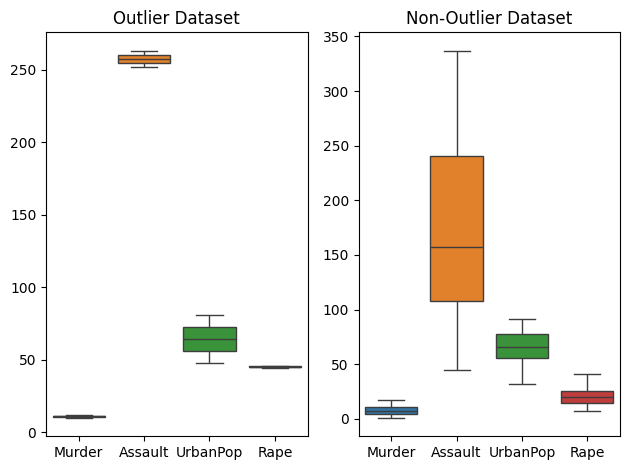

In [98]:
# Visualize dfOutliers and dfNoOutliers boxplots
figure, axes = plt.subplots(1, 2)
sns.boxplot(dfOutliers, ax=axes[0])
sns.boxplot(dfNoOutliers, ax=axes[1])
axes[0].title.set_text('Outlier Dataset')
axes[1].title.set_text('Non-Outlier Dataset')
plt.tight_layout()
plt.show()

#### 4. **Descriptive Analysis**
___

##### 4.1 **Features Central Tendency and Dispersion**

In [99]:
df_2.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


##### 4.2 **Feature Distribution**

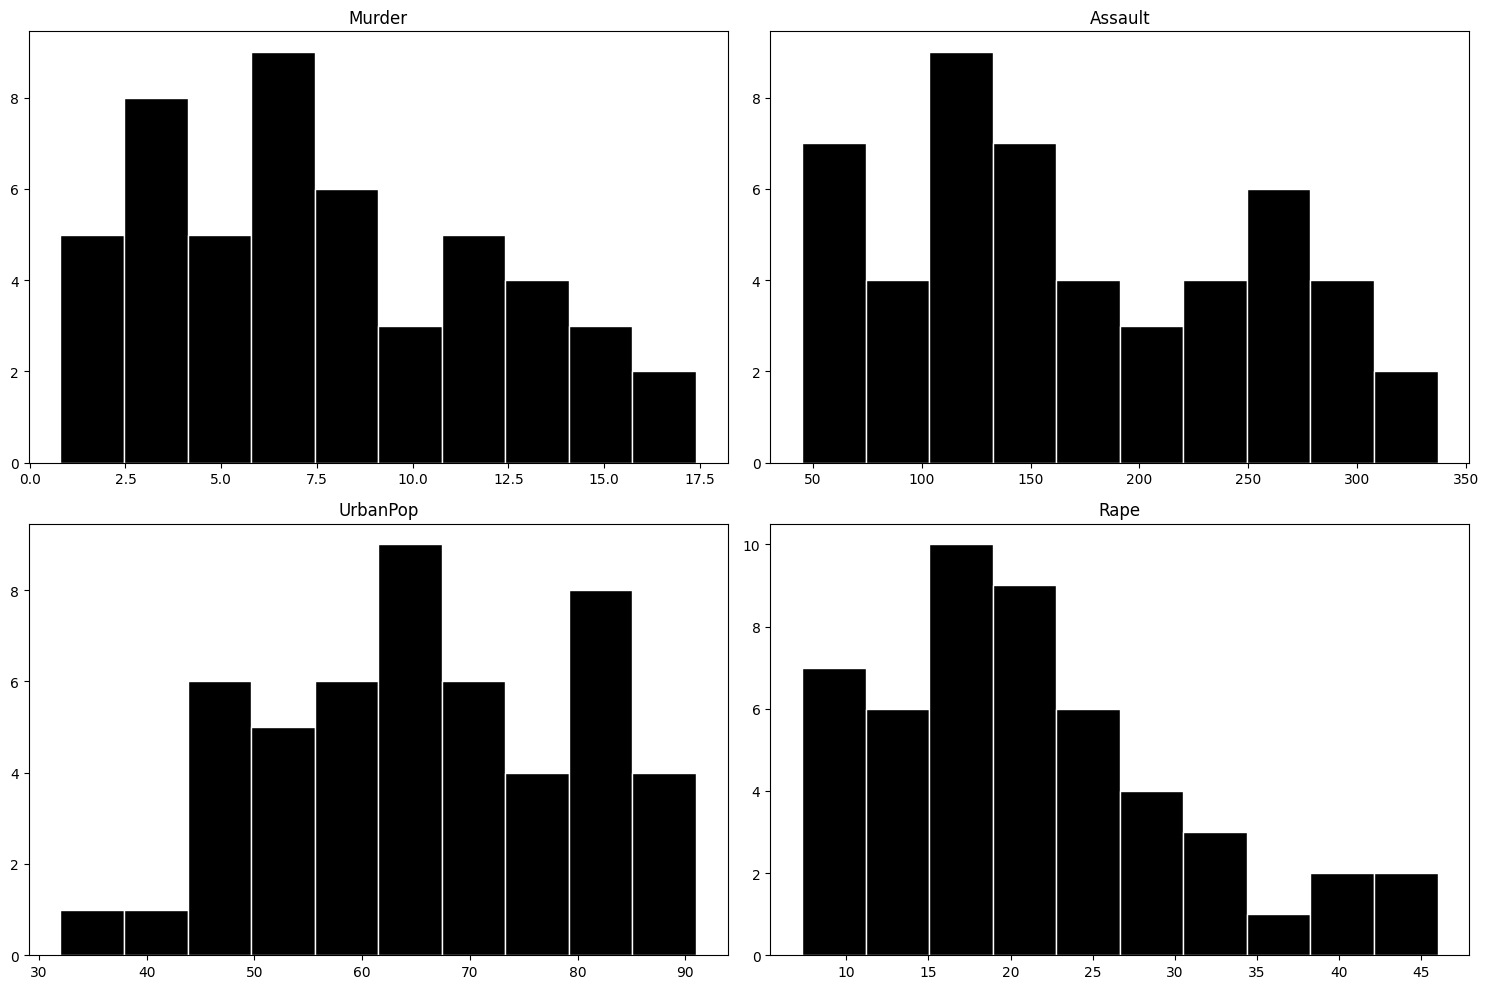

In [100]:
# Visualize the distribution of the numeric column features
df_2.hist(color='black', grid=False, figsize=(15, 10), edgecolor='white')
plt.tight_layout()
plt.show()

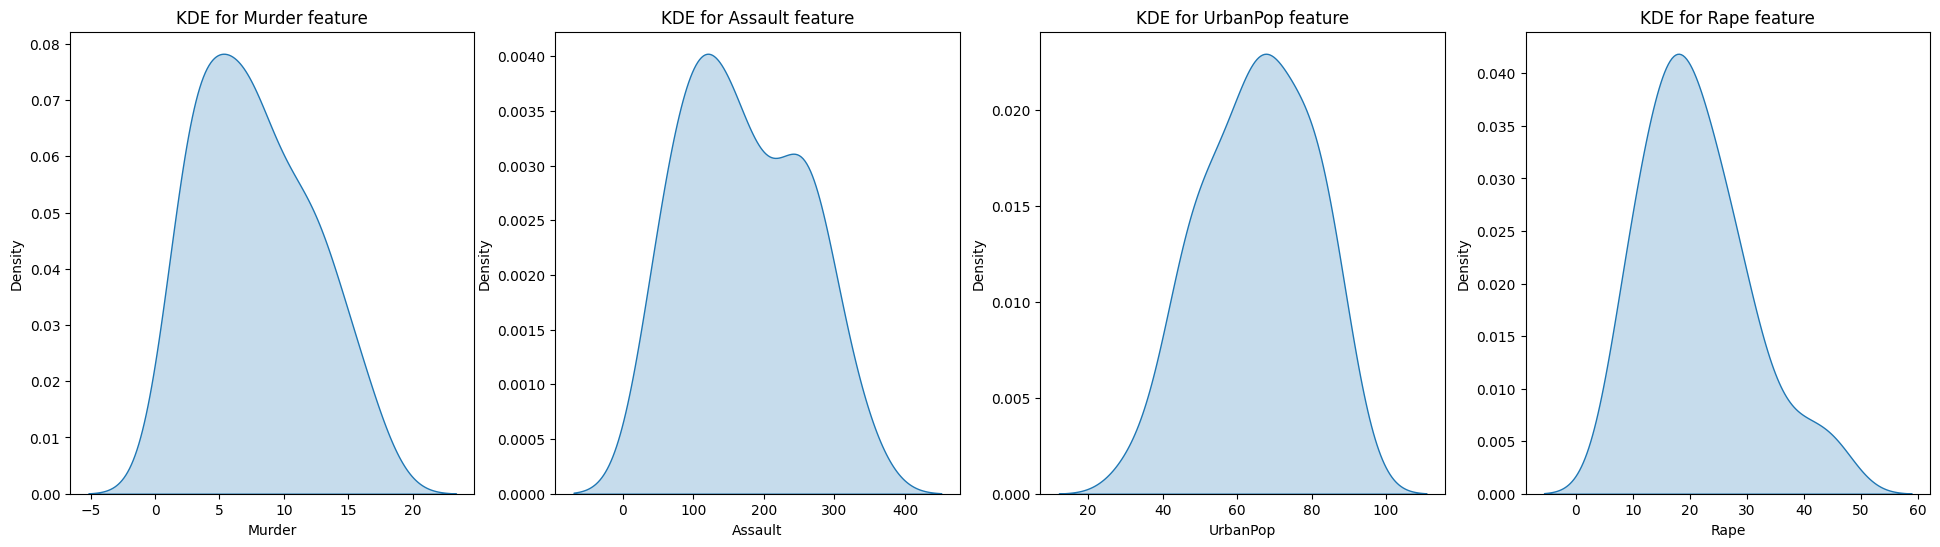

In [101]:
figure = plt.figure(figsize=(24, 6))
for i in range(4):
    plt.subplot(1, 4, 1+i)
    sns.kdeplot(data=df_2, x=dfNoOutliers.columns[i], fill=True)
    plt.title(f'KDE for {dfNoOutliers.columns[i]} feature')

In [102]:
for column in df_2:
    _skew = skew(df[column])
    _kurtosis = kurtosis(df[column], fisher=True)
    print(
        f"\n{column}\n"
        f"skew: {_skew:.4f}\n"
        f"kurtosis: {_kurtosis:.4f}"
    )

    # Perform Shapiro-Wilk test
    stat, p_value = shapiro(df[column])

    # Print the results
    print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpret the p-value
    alpha = 0.05
    if p_value > alpha:
        print("The data is likely normally distributed (fail to reject H0).")
    else:
        print("The data is not normally distributed (reject H0).")

    # Check the absolute values of each skew value of a feature
    if np.abs(_skew) < 0.5:
        print('distribution is almost symmetrical')
    elif 0.5 <= np.abs(_skew) <= 1:
        print('distribution is modertely skewed')
    else:
        print('distribution is highly skewed')
    
    # Extremity of tail distribution
    if _kurtosis > 0:
        print(
            f'Leptokurtic distribution - heavier tails and a sharper peak than the '
            f'normal distribution.\n'
            f'This type of distribution is often associated with higher peakedness '
            f'and a greater probability of extreme values.\n'
        )
    elif _kurtosis < 0:
        print(
            f'Platykurtic distribution - lighter tails and a flatter peak than the '
            f'normal distribution.\n'
            f'This type of distribution is often associated with less peakedness ' 
            f'and a lower probability of extreme values.\n'
        )
    else:
        print(
            f'Mesokurtic distribution - similar peak and tail shape as the normal '
            f'distribution.\n'
            )


Murder
skew: 0.3820
kurtosis: -0.8647
Shapiro-Wilk Test Statistic: 0.9570
P-value: 0.0667
The data is likely normally distributed (fail to reject H0).
distribution is almost symmetrical
Platykurtic distribution - lighter tails and a flatter peak than the normal distribution.
This type of distribution is often associated with less peakedness and a lower probability of extreme values.


Assault
skew: 0.2273
kurtosis: -1.0690
Shapiro-Wilk Test Statistic: 0.9518
P-value: 0.0405
The data is not normally distributed (reject H0).
distribution is almost symmetrical
Platykurtic distribution - lighter tails and a flatter peak than the normal distribution.
This type of distribution is often associated with less peakedness and a lower probability of extreme values.


UrbanPop
skew: -0.2192
kurtosis: -0.7842
Shapiro-Wilk Test Statistic: 0.9771
P-value: 0.4385
The data is likely normally distributed (fail to reject H0).
distribution is almost symmetrical
Platykurtic distribution - lighter tails and

`NOTES`:

* To interpret the values of kurtosis and skewness, we need to first understand what the two statistical terms mean. Skewness measures the symmetry of a features distribution. It explains whether the data leans more towards one side, or whether it is symmetrical. A positive skew, would be the mean of the a feature being on the left of the median of the feature, whilst the mode would be on the right of the features median value. A negative skew would have the mode of the feature on the right of the median value of the feature, whilst the mean value would be on the left of the median value. With Kurtosis, we measure the extremity of the distribution's tails compared to a normal distribution. It shows how much outlier-prone a distribution is.(Menon, 2024)

* Mesokurtic: A distribution with mesokurtic kurtosis has a similar peak and tail shape as the normal distribution. It has a kurtosis value of around 0, indicating that its tails are neither too heavy nor too light compared to a normal distribution. (Suvarna, 2024)

* Leptokurtic: A distribution with leptokurtic kurtosis has heavier tails and a sharper peak than the normal distribution. It has a positive kurtosis value, indicating that it has more extreme outliers than a normal distribution. This type of distribution is often associated with higher peakedness and a greater probability of extreme values. (Suvarna, 2024)

* Platykurtic: A distribution with platykurtic kurtosis has lighter tails and a flatter peak than the normal distribution. It has a negative kurtosis value, indicating that it has fewer extreme outliers than a normal distribution. This type of distribution is often associated with less peakedness and a lower probability of extreme values. (Suvarna, 2024)

* On top of the features skeweness and kurtosis values, comparing the shapiro-wilk test score to the threshold of 0.05, we can see that the null hypothesis is rejected by all the features, signaling that none of the features distribution can be defined as normal. This will need to be taken into consideration when scaling the data. 

#### 5. **Dataset Scaling**
___

`NOTES`:

* The features have a non-normal distribution, with only the Rape feature expressing a moderately skewed distribution, suggesting that when scaling the features, a MinMaxScaler should be used. 

In [103]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the dataset
scaled_data = scaler.fit_transform(df_2)

# Store the scaled data as a dataset
df_scaled = pd.DataFrame(scaled_data, columns=df_2.columns, index=df_2.index)

df_scaled.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


#### 6. **Correlation Analysis**
___

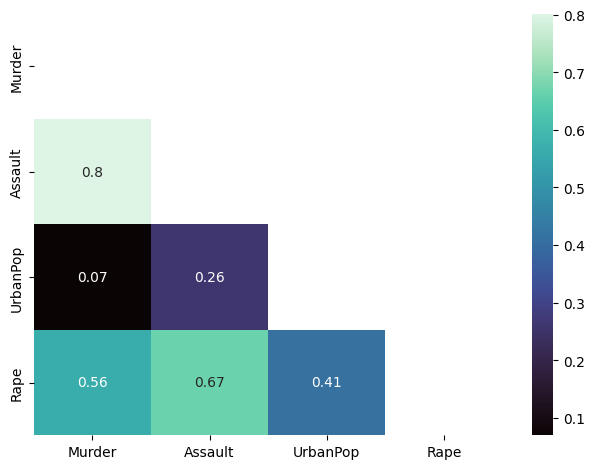

In [104]:
# Create correlation df
corr_df = df_scaled.corr()
# Create a mask to hide the upper triangle of the correlation matrix including the diagonal
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
# Visualize heatmap 
sns.heatmap(corr_df, mask=mask_ut, cmap="mako", annot=True, edgecolor='white')
plt.tight_layout()
plt.show()

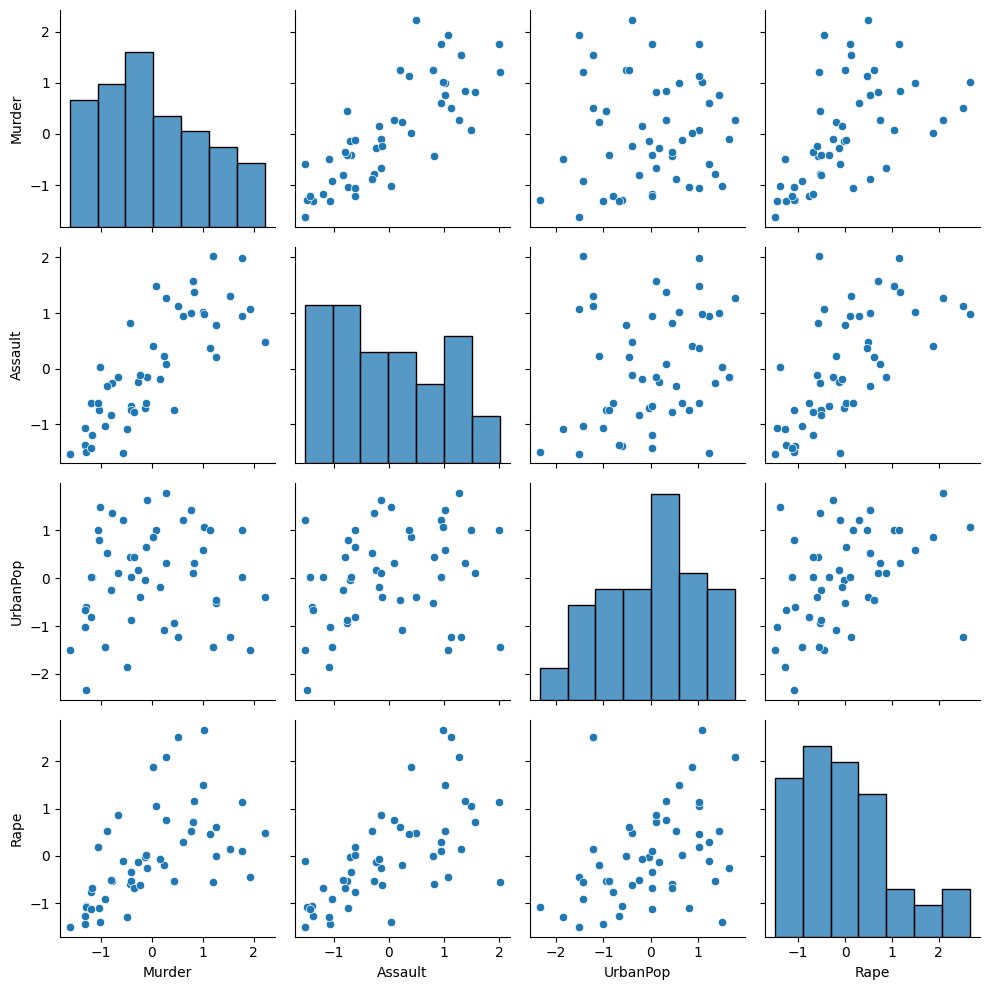

In [105]:
# Visualize the relationship between the features
sns.pairplot(df_scaled)
plt.tight_layout()
plt.show()

`NOTES`:

* Before we can interpret the correlation coefficients, we need to understand what the ranges mean. In her article, 'Correlation Coefficient | Types, Formulas & Examples' Pritha describes the ranges as follows: 0.7 to 1 (very strong), 0.5 to 0.7 (Strong), 0.3 to 0.5 (Moderate), 0 to 0.3 (Weak), 0 (None).(Bhandari, 2023).(Absolute values were used, therefore, negative values within the same range would still describe the same strength, just as a negative relation).  

* Understanding these coefficient values, we can see from the correlation matrix that the relationship between Assault and Murder (0.80) can be describe as a very strong positive relationship. Another two strong postive relationships exists between Rape and Assault (0.68), Rape and Murder (0.58). The relationship between Rape and UrbanPop with 0.43 can be seen as a moderate positive relationship.

* Because of the low strength of relationship between UrbanPop and the other features suggests that the feature is the most unique feature within the dataset. 

* The pairplot is a plot that illustrates to us the relationship between different features in the dataset, as well as the distribution within each feature. In our case, looking for the correlation of features becomes a little difficult because the visualizations of the scatterplots isn't completely obvious. However, the relationship between the Assault and Murder features, can still be clearly seen as the strongest positive relationship between the features. The relationships with UrbanPop, excluding Rape, can also be seen as "random" as the plots are scattered without a distinguishable pattern.

`PRE-PROCESSING SUMMARY`:

* There is no column with a strong skew therefore it was decided to scale features using normalization, using the MinMaxScaler() from the sklearn library.

## **PCA Application**
___

In [106]:
# Instantiate the PCA object
pca = PCA()

# Isolate the numeric features from the dataset and remove the city value 
X = df_scaled.values

# Fit using the scaled features
pca = pca.fit(X)

# Transform pca using scaled features
pca_transform = pca.transform(X)

# # Reaturn the PCA as a dataframe 
pca_df = pd.DataFrame(pca_transform, index=df_2.index)
pca_df.head()

,0,1,2,3
City,,,,
Alabama,0.985566,-1.133392,-0.444269,-0.156267
Alaska,1.950138,-1.073213,2.040003,0.438583
Arizona,1.763164,0.745957,0.054781,0.834653
Arkansas,-0.141420,-1.119797,0.114574,0.182811
California,2.523980,1.542934,0.598557,0.341996


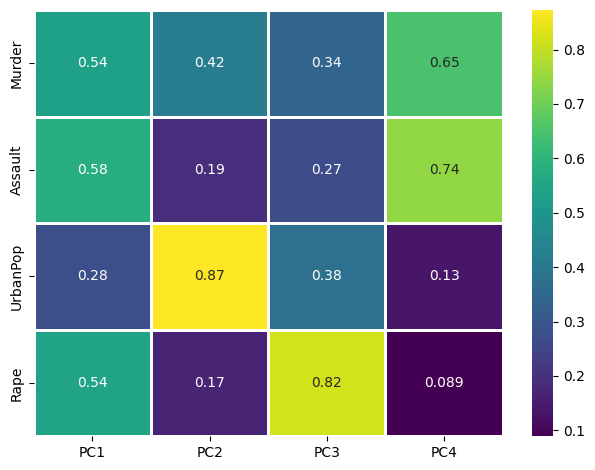

In [107]:
# Create a DataFrame for PCA components feature importance
loadings = pd.DataFrame(np.abs(pca.components_.T),
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                        index=df_scaled.columns)

sns.heatmap(data=loadings, cmap='viridis', annot=True, linewidths=1)
plt.tight_layout()
plt.show()

`NOTES`:

* Based on the heatmap of the loadings dataframe, we can see that UrbanPop feature is captured mostely within the second principle component, where most of the Assault variance can be found in the fourth principle component, whilst component 1 tends to be a more balanced share between the features, when the third principle component is responsible for the Rape feature. 

In [108]:
# Store the variance ratio that explains percentage of variance of the selected components
variance_ratio = pca.explained_variance_ratio_ * 100
variance_ratio = variance_ratio.reshape(len(variance_ratio), -1)
# Return as a dataframe
variance_df = pd.DataFrame(data=variance_ratio, index=['PC1', 'PC2', 'PC3', 'PC4'])
variance_df.T

,PC1,PC2,PC3,PC4
0,62.006039,24.744129,8.91408,4.335752


`NOTES`:

* From the variance_df we can see that the PC1 captures *62.01%* of the variance from the reduced features, with PC2 making *24.74%*, and PC3 making *8.91%* raising the total variance captured by these two components to a total of *95.70%.* Therefore the we can see that the most optimal number of components that catches the most ideal variance between the features would be three components.

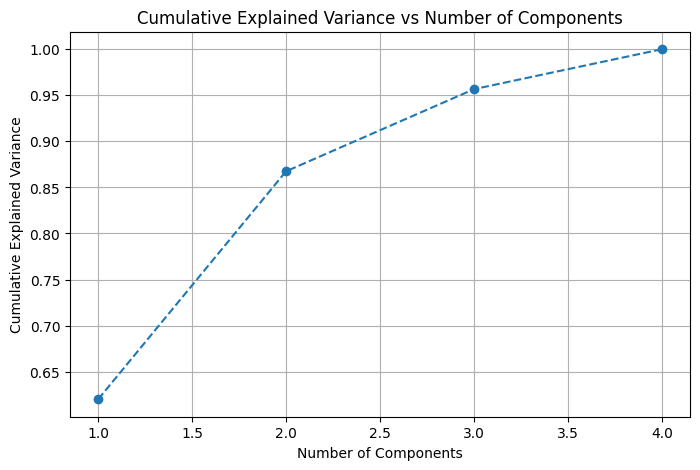

In [109]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), 
         cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

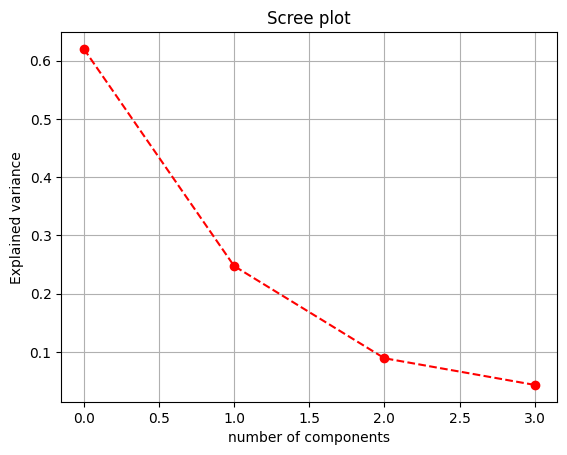

In [110]:
# Scree plot
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--', c='r')
plt.xlabel('number of components')
plt.ylabel('Explained variance')
plt.title("Scree plot")
plt.grid(True)
plt.show()

`NOTES`:

* Based on the scree plot we can see that the most variance is captured through the second principle component and the elbow runs from 2 Components, to 3. When using the cummulative explained variance plot, we see that 2 components only account for slightly above 85% percent of the variance of all the features. When looking at the cummulative explained variance plot, we can see that 3 components account for slightly more than 95% of the variance of all the features, and therefore we will be selecting 3 components because of the confluence of information from the scree plot and the cummulative explained variance plot at three components. (Chatgpt, 2024) 

## **Clustering**
___

#### 1. **Seleting K**

In [111]:
# Output the pca_df with the three principal components.
pca_df.loc[:, :2]

,0,1,2
City,,,
Alabama,0.985566,-1.133392,-0.444269
Alaska,1.950138,-1.073213,2.040003
Arizona,1.763164,0.745957,0.054781
Arkansas,-0.141420,-1.119797,0.114574
California,2.523980,1.542934,0.598557
Colorado,1.514563,0.987555,1.095007
Connecticut,-1.358647,1.088928,-0.643258
Delaware,0.047709,0.325359,-0.718633
Florida,3.013042,-0.039229,-0.576829


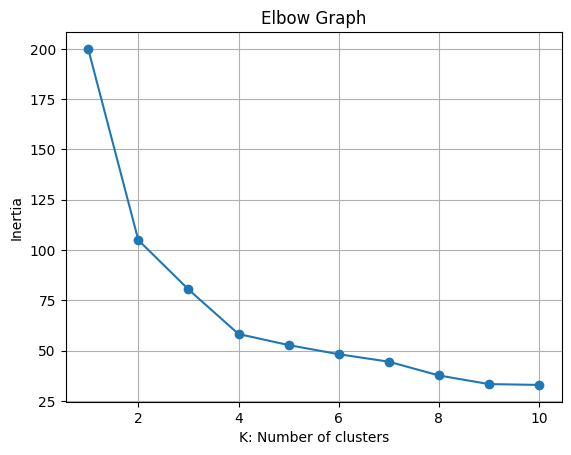

In [112]:
def eval_Kmeans(X, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(X)    
    return kmeans.inertia_

def elbow_Kmeans(X, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(X, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K: Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Graph')
    plt.grid(True)
    plt.show()

elbow_Kmeans(pca_df)

`NOTES`

* The elbow runs from K=2 to K=4. In cases like this, it is not always clear which value within the elbow is the most optimal, so we can investigate likely candidates further using the silhouette score. 

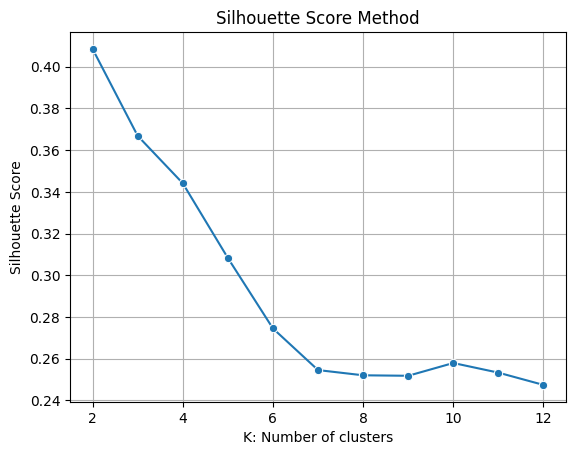

In [113]:
# Silhouette score method
kmax = 12
sil = []
plt.plot()
for k in range(2, kmax+1,):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    kmeans.fit(pca_df)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('K: Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

`NOTES`:

* We can see from the Silhouette Score, that between the range of 2 to 4 clusters, the Silhouette Score at 2 clusters is higher, which proves 2 clusters to be the most optimal number of clusters to have. 

In [114]:
pca_df.head()

,0,1,2,3
City,,,,
Alabama,0.985566,-1.133392,-0.444269,-0.156267
Alaska,1.950138,-1.073213,2.040003,0.438583
Arizona,1.763164,0.745957,0.054781,0.834653
Arkansas,-0.141420,-1.119797,0.114574,0.182811
California,2.523980,1.542934,0.598557,0.341996


#### 2. **3-D Kmeans plot**

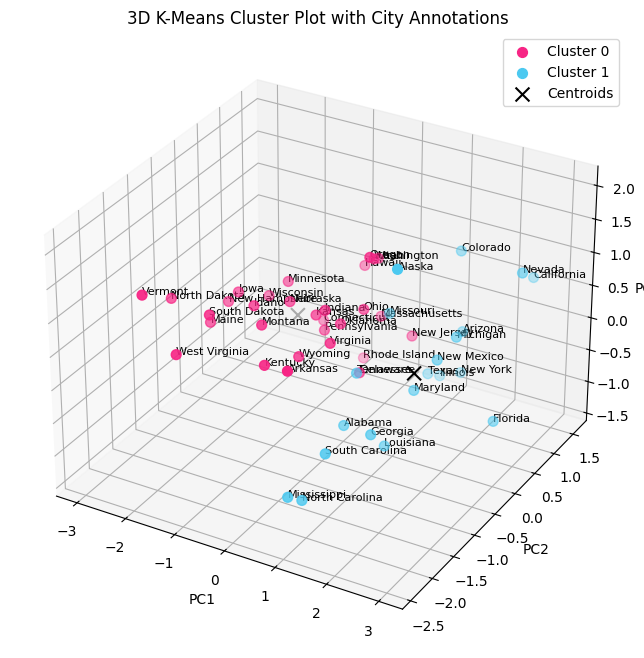

In [115]:
# Extract the three components
x = pca_df.iloc[:, 0]
y = pca_df.iloc[:, 1]
z = pca_df.iloc[:, 2]

# Fit k-means
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Define colors for the clusters
colours = ['#f72585', '#4cc9f0']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with 'o' marker
for i in range(k):
    cluster_points = ax.scatter(x[cluster_labels == i], y[cluster_labels == i], z[cluster_labels == i],
                                color=colours[i], label=f'Cluster {i}', marker='o', s=50)

    # Annotate the cities (using pca_df index as city names)
    for j in pca_df.index[cluster_labels == i]:
        ax.text(x[j], y[j], z[j], f'{j}', size=8, zorder=1, color='black')

# Plot the centroids
ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], color='black', marker='x', s=100, label='Centroids')

# Set labels
ax.set_title('3D K-Means Cluster Plot with City Annotations')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Show legend
ax.legend()

# Display the plot
plt.show()

#### 3. **Cluster Analysis**

In [116]:
# Add the cluster prediction labels to original dataset
df['Cluster'] = cluster_labels
df.head()

,Murder,Assault,UrbanPop,Rape,Cluster
City,,,,,
Alabama,13.2,236,58,21.2,1
Alaska,10.0,263,48,44.5,1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1


C:\Users\Lenovo S145\AppData\Local\Temp\ipykernel_15944\3810335129.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=df['Murder'], palette='gray', linewidth=1.0)
C:\Users\Lenovo S145\AppData\Local\Temp\ipykernel_15944\3810335129.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=df['Assault'], palette='gray', linewidth=1.0)
C:\Users\Lenovo S145\AppData\Local\Temp\ipykernel_15944\3810335129.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=df['UrbanPop'], palette='gray', linewidth=1.0)
C:\Users\Lenovo S145\AppData\Local\

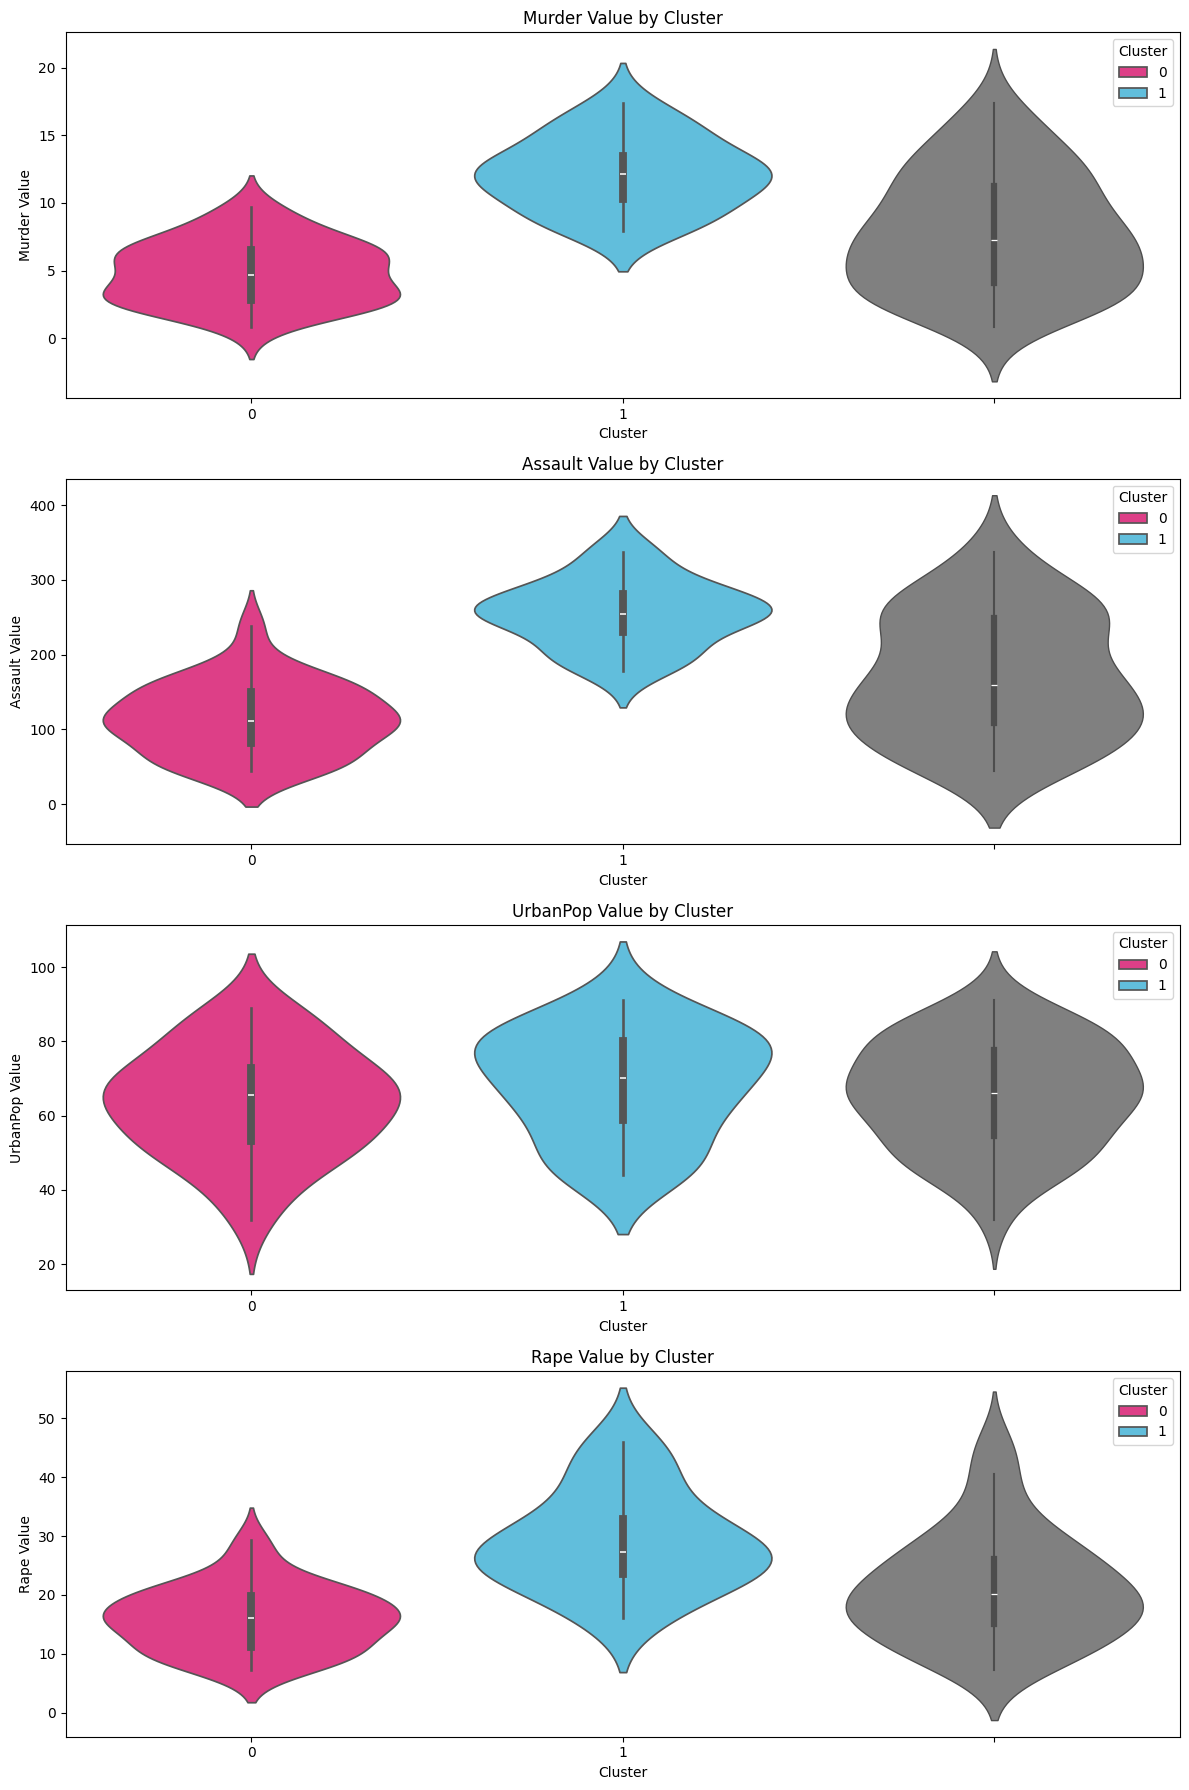

In [117]:
plt.figure(figsize=(12, 18))

plt.subplot(4, 1, 1)
sns.violinplot(x=df['Cluster'], y=df['Murder'], palette=colours, hue=df['Cluster'])
sns.violinplot(y=df['Murder'], palette='gray', linewidth=1.0)
plt.title('Murder Value by Cluster')
plt.ylabel('Murder Value')

plt.subplot(4, 1, 2)
sns.violinplot(x=df['Cluster'], y=df['Assault'], palette=colours, hue=df['Cluster'])
sns.violinplot(y=df['Assault'], palette='gray', linewidth=1.0)
plt.title('Assault Value by Cluster')
plt.ylabel('Assault Value')

plt.subplot(4, 1, 3)
sns.violinplot(x=df['Cluster'], y=df['UrbanPop'], palette=colours, hue=df['Cluster'])
sns.violinplot(y=df['UrbanPop'], palette='gray', linewidth=1.0)
plt.title('UrbanPop Value by Cluster')
plt.ylabel('UrbanPop Value')

plt.subplot(4, 1, 4)
sns.violinplot(x=df['Cluster'], y=df['Rape'], palette=colours, hue=df['Cluster'])
sns.violinplot(y=df['Rape'], palette='gray', linewidth=1.0)
plt.title('Rape Value by Cluster')
plt.ylabel('Rape Value')

plt.tight_layout()
plt.show()

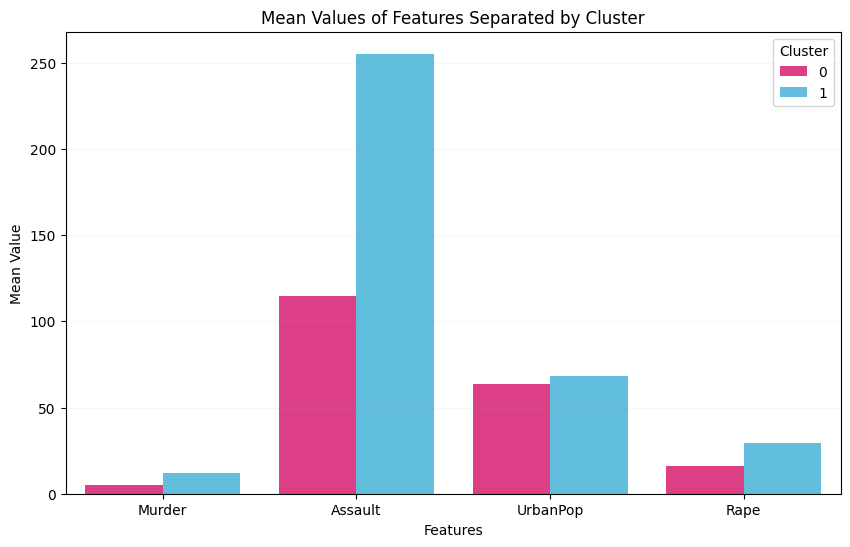

In [118]:
# Melt the DataFrame to long format
df_melted = pd.melt(df, id_vars='Cluster', value_vars=df_2.iloc[:, 0:4].columns, var_name='feature', value_name='value')

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='feature', y='value', hue='Cluster', data=df_melted, estimator='mean', errorbar=None, palette=['#f72585', '#4cc9f0'])
plt.grid(True, 'major', 'y', alpha=0.1)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean Values of Features Separated by Cluster')
plt.show()

`NOTES`:

**Cluster 0:**

**`Low Crime Cluster`**
___
* Reasoning: 
    * The UrbanPop across both clusters seem to be balanced and mirrors the mean value of the UrbanPop feature for the entire dataset. 
    * Looking at the distribution of the violin plots across all the crime features for this cluster, we can see that the mean and median values are within the first quantile (25%) of the dispersion of the each of the crime features.

**Cluster 1:** 

**`High Crime Cluster`**
___
* Reasoning: 
    * Contrary to the first cluster, the mean and median values from this cluster are found in the extreme values of the crime features, as these values can be found within the upper wick of the crime features boxplot. 

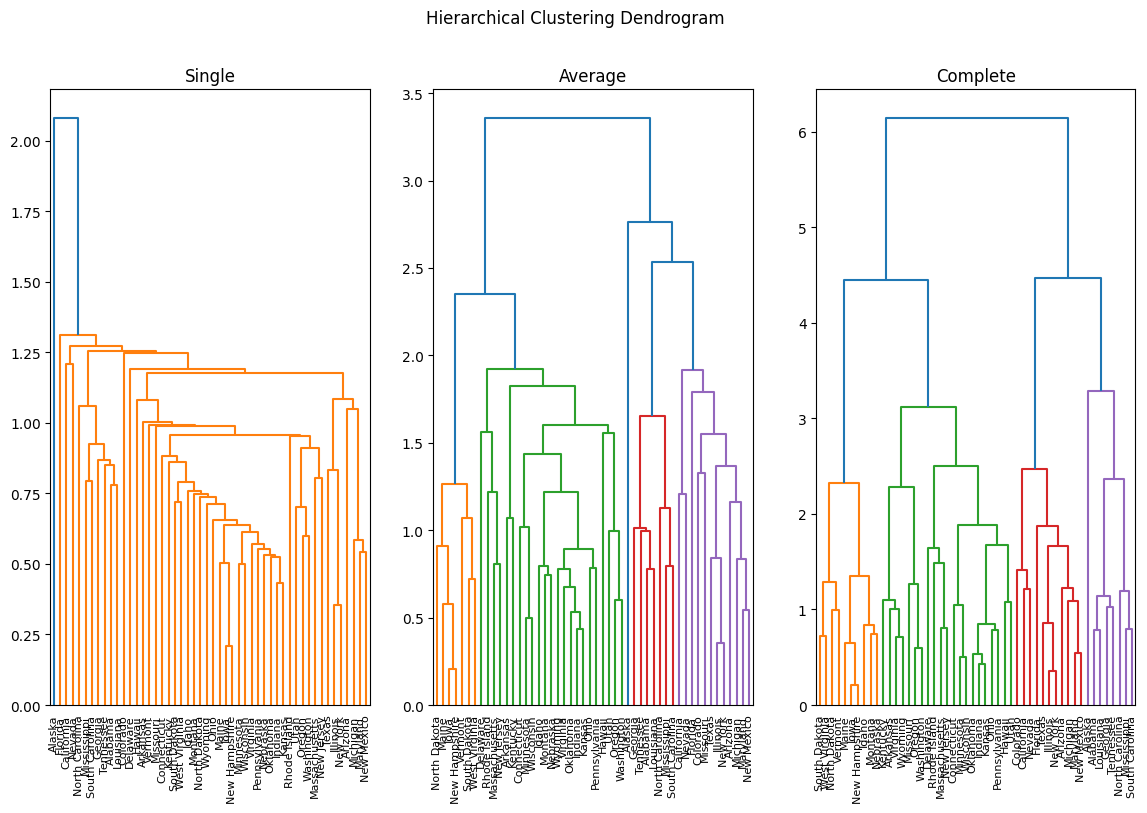

In [119]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1)
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

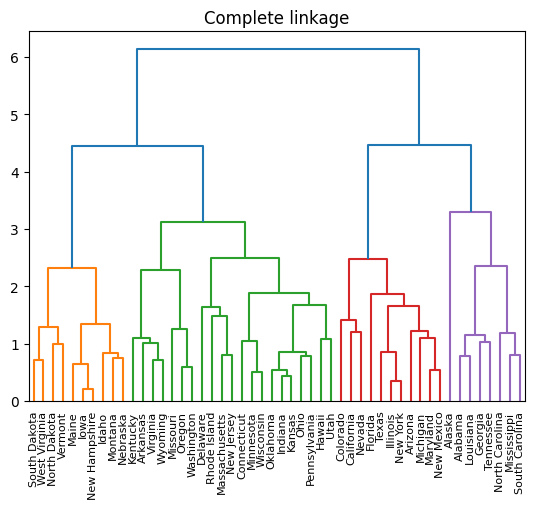

In [120]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

`NOTES`:

* Based on the Complete linkage dendogram, we can see that the data was clustered into 4 seperate clusters. This is in contrast to the 2 clusters identified by the KMeans clustering method. 

## **Bibliography**
___

1. Bhandari, P. (2023), 'Correlation Coefficient | Types, Formulas & Examples', _Scribbr_, 22 June, Available at: https://www.scribbr.com/statistics/correlation-coefficient/ (Accessed on: 05 Septemeber 2024)

2. Menon, K. (2024), _The Complete Guide to Skewness and Kurtosis_. Available at: https://www.simplilearn.com/tutorials/statistics-tutorial/skewness-and-kurtosis (Accessed: 08 September 2024)

3. Suvarna (2024), _Difference Between Skewness and Kurtosis_. Available at: https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/ (Accessed: 08 September 2024)

4. OpenAI. (2024). ChatGPT [Large language model]. https://chatgpt.com/c/66e1e049-1c4c-8002-8d16-f4493d15b72f